In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
# Load Train and Competition Dataset
train_raw_dataset = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

y_train_raw = tf.keras.utils.to_categorical(train_raw_dataset.pop('label'), num_classes=10, dtype='uint8')
X_train_raw = train_raw_dataset / 255.0
competition_raw_dataset = pd.read_csv('/kaggle/input/digit-recognizer/test.csv') / 255.0

In [3]:
# Resize image  
IMG_SIZE = 28
X_train_raw = X_train_raw.values.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
competition_raw_dataset = competition_raw_dataset.to_numpy().reshape(-1, IMG_SIZE, IMG_SIZE, 1)

print("Training set (images) shape: {shape}".format(shape=X_train_raw.shape))
print("Training set (labels) shape: {shape}".format(shape=y_train_raw.shape))
print("Competition set (images) shape: {shape}".format(shape=competition_raw_dataset.shape))

Training set (images) shape: (42000, 28, 28, 1)
Training set (labels) shape: (42000, 10)
Competition set (images) shape: (28000, 28, 28, 1)


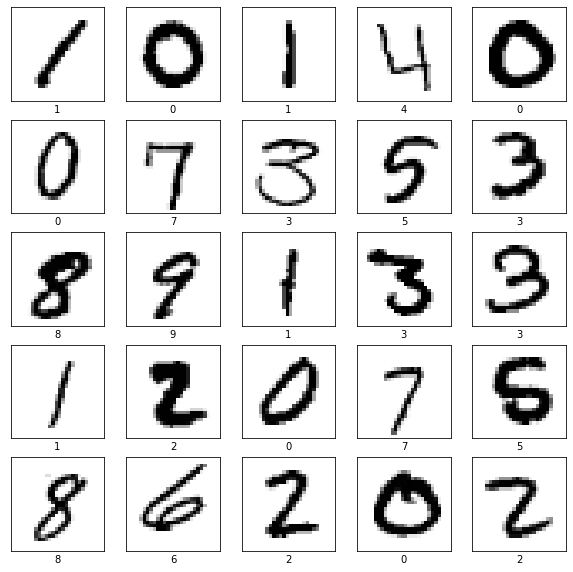

In [4]:
# Plot Images
PLOT_SIZE = 5
plt.figure(figsize=(10,10))
for i in range(PLOT_SIZE * PLOT_SIZE):
    plt.subplot(PLOT_SIZE, PLOT_SIZE, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train_raw[i][:, :, 0], cmap=plt.cm.binary)
    plt.xlabel(y_train_raw[i].tolist().index(1))
plt.show()

In [5]:
# Split Training and Testing Set
RANDOM_STATE = 7
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, 
                                                    test_size=TEST_SIZE, random_state = RANDOM_STATE)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.dtypes.cast(X_train, tf.float64), tf.dtypes.cast(y_train, tf.uint8)))
test_dataset = tf.data.Dataset.from_tensor_slices((tf.dtypes.cast(X_test, tf.float64), tf.dtypes.cast(y_test, tf.uint8)))
competition_dataset = tf.data.Dataset.from_tensor_slices(tf.dtypes.cast(competition_raw_dataset, tf.float64))

print("Training set ({shape}): {data}".format(shape=len(train_dataset), data=train_dataset))
print("Test set ({shape}): {data}".format(shape=len(test_dataset), data=test_dataset))
print("Competition set ({shape}): {data}".format(shape=len(competition_dataset), data=competition_dataset))

Training set (37800): <TensorSliceDataset shapes: ((28, 28, 1), (10,)), types: (tf.float64, tf.uint8)>
Test set (4200): <TensorSliceDataset shapes: ((28, 28, 1), (10,)), types: (tf.float64, tf.uint8)>
Competition set (28000): <TensorSliceDataset shapes: (28, 28, 1), types: tf.float64>


In [6]:
## Performance Tunning
# .batch() divides data into sets
# .shuffle() randomize data
# .cache() loads data into memory
# .prefetch() decouples loading and training process
# https://www.tensorflow.org/guide/data_performance

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
competition_dataset = competition_dataset.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        51264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

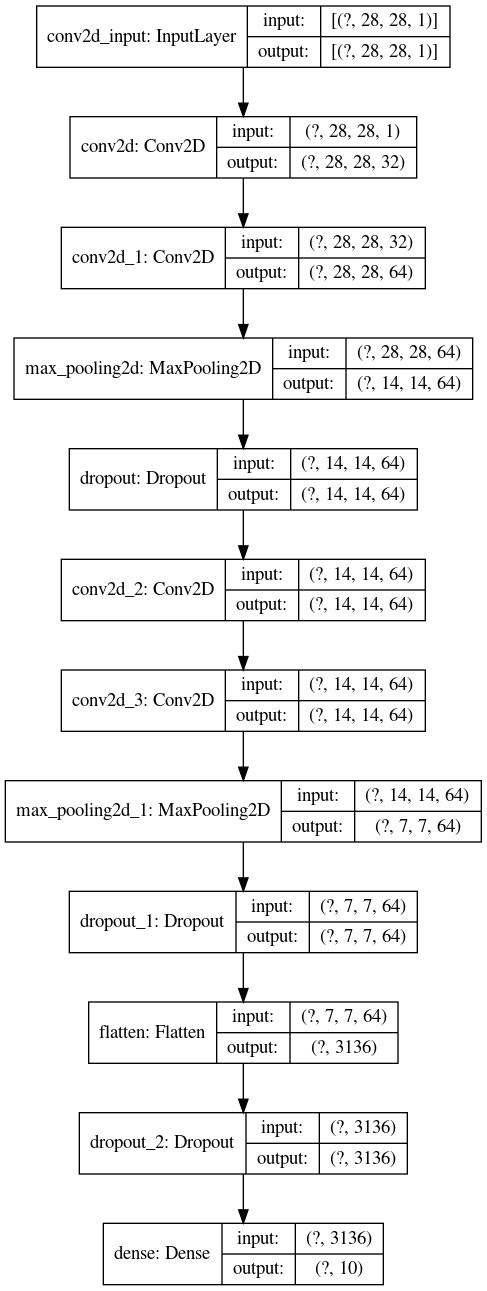

In [7]:
# Construct a Standard CNN model for training
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding = 'same', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()
tf.keras.utils.plot_model(model, "model.png", show_shapes=True)

In [8]:
# Define the optimizer
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-7, centered=False)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation to prevent overfitting
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

# Progressively reduce learning rate
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                                               factor=0.5, min_lr=0.00001)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                             patience=1, verbose=1, mode='auto')

In [9]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE), 
                    epochs=20, callbacks=[learning_rate_reduction, earlystopper])

Epoch 1/20
591/591 [==============================] - 12s 20ms/step - loss: 0.4310 - accuracy: 0.8605
Epoch 2/20
591/591 [==============================] - 11s 19ms/step - loss: 0.1420 - accuracy: 0.9580
Epoch 3/20
591/591 [==============================] - 12s 21ms/step - loss: 0.1006 - accuracy: 0.9683
Epoch 4/20
591/591 [==============================] - 12s 20ms/step - loss: 0.0839 - accuracy: 0.9740
Epoch 5/20
591/591 [==============================] - 12s 20ms/step - loss: 0.0785 - accuracy: 0.9761
Epoch 6/20
591/591 [==============================] - 12s 21ms/step - loss: 0.0673 - accuracy: 0.9794
Epoch 7/20
591/591 [==============================] - 12s 21ms/step - loss: 0.0659 - accuracy: 0.9814
Epoch 8/20
591/591 [==============================] - 12s 21ms/step - loss: 0.0596 - accuracy: 0.9815
Epoch 9/20
591/591 [==============================] - 12s 21ms/step - loss: 0.0590 - accuracy: 0.9825
Epoch 10/20
591/591 [==============================] - 12s 20ms/step - loss: 0.057

In [10]:
# Evaluate the model
model.evaluate(test_dataset)

66/66 [==============================] - 0s 3ms/step - loss: 0.0483 - accuracy: 0.9907


[0.04825799912214279, 0.9907143115997314]

In [11]:
# Predict for competition
predictions = model.predict_classes(competition_dataset)
indices = np.arange(1, competition_raw_dataset.shape[0]+1)

# Save output
from datetime import datetime
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

output = pd.DataFrame({'ImageId': indices, 'Label': predictions})
output.to_csv('submission_CNN_' + timestamp + '.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [12]:
# Construct an one-layer NN model for training
modelNN = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Define the optimizer
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-7, centered=False)
modelNN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

modelNN.summary()

historyNN = modelNN.fit(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE), epochs=5, 
                        callbacks=[learning_rate_reduction, earlystopper])

# Evaluate NN model
modelNN.evaluate(test_dataset)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
591/591 [==============================] - 10s 17ms/step - loss: 0.7512 - accuracy: 0.7673
Epoch 2/5
591/591 [==============================] - 11s 19ms/step - loss: 0.3798 - accuracy: 0.8874
Epoch 3/5
591/591 [=========================

[0.10309227555990219, 0.9733333587646484]

In [13]:
# Predict for competition using single layer NN
predictions = modelNN.predict_classes(competition_dataset)
indices = np.arange(1, competition_raw_dataset.shape[0]+1)

# Save output
from datetime import datetime
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

output = pd.DataFrame({'ImageId': indices, 'Label': predictions})
output.to_csv('submission_random_forest_' + timestamp + '.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Alternatively, use keras functional api to build an inter-connected CNN (ResNet)

Model: "toy_ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   832         image_input[0][0]                
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 64)   51264       conv2d_4[0][0]                   
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 28, 28, 64)   0           conv2d_5[0][0]                   
_________________________________________________________________________________________

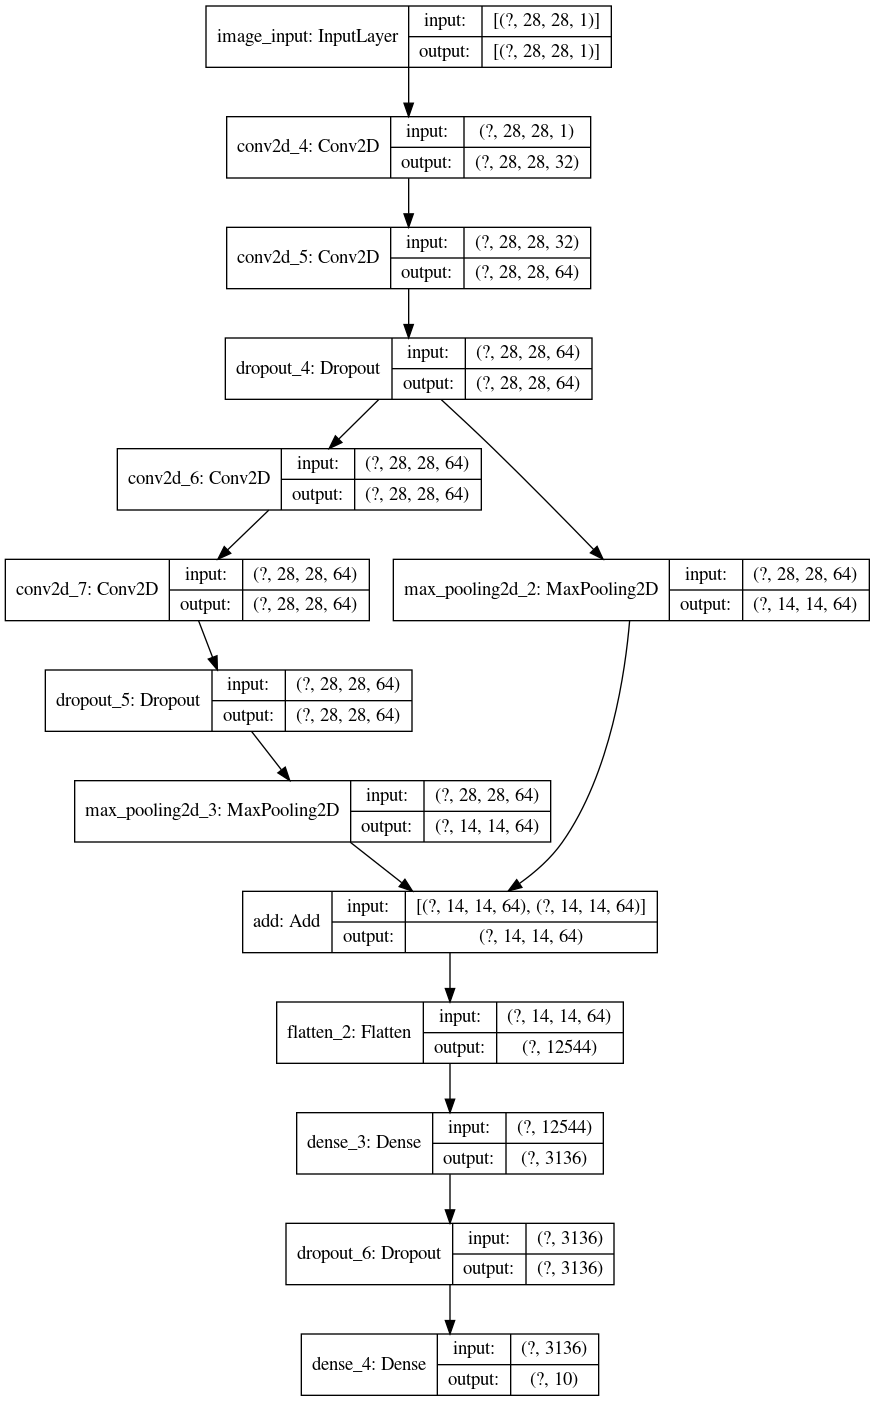

In [14]:
inputs = tf.keras.Input(shape=(28, 28, 1), name="image_input")

x = tf.keras.layers.Conv2D(32, (5, 5), activation="relu", padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, (5, 5), activation="relu", padding='same')(x)
x = tf.keras.layers.Dropout(0.25)(x)
block_1_output = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same')(x)
x = tf.keras.layers.Dropout(0.25)(x)
block_2_output = tf.keras.layers.add([tf.keras.layers.MaxPooling2D((2, 2))(x), block_1_output])

x = tf.keras.layers.Flatten()(block_2_output)
x = tf.keras.layers.Dense(3136, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

modelCINN = tf.keras.Model(inputs=inputs, outputs=outputs, name="toy_ResNet")
modelCINN.summary()

# Plot the layers
tf.keras.utils.plot_model(modelCINN, "CINN.png", show_shapes=True)

In [15]:
# Define the optimizer
# https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-7, centered=False)
modelCINN.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation to prevent overfitting
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(X_train)

# Progressively reduce learning rate
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
                                                               factor=0.5, min_lr=0.00001)
earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                             patience=1, verbose=1, mode='auto')

history = modelCINN.fit(datagen.flow(X_train,y_train, batch_size=BATCH_SIZE), 
                    epochs=20, callbacks=[learning_rate_reduction, earlystopper])

Epoch 1/20
591/591 [==============================] - 15s 25ms/step - loss: 0.2990 - accuracy: 0.9088
Epoch 2/20
591/591 [==============================] - 14s 24ms/step - loss: 0.0962 - accuracy: 0.9713
Epoch 3/20
591/591 [==============================] - 16s 27ms/step - loss: 0.0752 - accuracy: 0.9776
Epoch 4/20
591/591 [==============================] - 14s 24ms/step - loss: 0.0674 - accuracy: 0.9803
Epoch 5/20
591/591 [==============================] - 16s 27ms/step - loss: 0.0651 - accuracy: 0.9808
Epoch 6/20
591/591 [==============================] - 14s 24ms/step - loss: 0.0658 - accuracy: 0.9816
Epoch 7/20
591/591 [==============================] - 16s 27ms/step - loss: 0.0642 - accuracy: 0.9820
Epoch 8/20
591/591 [==============================] - 14s 24ms/step - loss: 0.0646 - accuracy: 0.9815
Epoch 9/20
591/591 [==============================] - 16s 27ms/step - loss: 0.0646 - accuracy: 0.9820
Epoch 10/20
591/591 [==============================] - 15s 25ms/step - loss: 0.067

In [16]:
modelCINN.evaluate(test_dataset)

66/66 [==============================] - 0s 4ms/step - loss: 0.0553 - accuracy: 0.9914


[0.05525994673371315, 0.991428554058075]

In [17]:
# Predict for competition
predictions = np.argmax(modelCINN.predict(competition_dataset), axis = 1)
indices = np.arange(1, competition_raw_dataset.shape[0]+1)

# Save output
from datetime import datetime
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

output = pd.DataFrame({'ImageId': indices, 'Label': predictions})
output.to_csv('submission_RestNet_' + timestamp + '.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
